# Access Database-Files to explore and summerise Data

In [365]:
import pandas as pd
import numpy as np
import pylab as plt
from tables import *
import sqlite3
import openpyxl as oxl

In [366]:
# aims 
    # plot single data and highlight outliers in data
    # compare epsilon values of different evaluation methods
    # summarise data
    # calculate epsilon values with SSB
    # visulise data for epsilon SSB
    # store summarised data in hd5

In [367]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-01-09/data_eval_new/"
file_name = "int_norm_20150109_bgd_new_den.h5"
path_comp = '/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/'
sum_file = "int_norm_comp_new.h5"

In [368]:
hdf5_file = pd.HDFStore(path+file_name)
#hdf5_sum_file = pd.HDFStore(path_comp+sum_file)

# Methods for Outlier rejection, Summarise and SSB Calculation

In [369]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(~mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Cycle", "Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Cycle"] = df["Cycle"]
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def mad_outlier_mean(df):
    data_sample_outlier = pd.DataFrame()
    df_strings = df[df.columns[df.dtypes == 'object']]
    df_values = df[df.columns[df.dtypes != 'object']]
    columns = df_values.columns.drop(["Filenumber"]).tolist()
    
    for column in columns:
        data_sample_outlier[column] = df_values[column].where(mad_based_outlier(df_values[column]), other=np.NaN)
    
    data_sample_outlier["Filenumber"] = df["Filenumber"]
    data_sample_outlier["Sample"] = df["Sample"]
    data_sample_outlier = data_sample_outlier.dropna(how = "all")
    #df_strings = df_strings[data_sample_outlier.Cycle == df_strings.Cycle]
    #df_strings = df_strings.drop("Cycle", axis = 1)
    #data_sample_outlier = pd.concat([df_strings, data_sample_outlier], axis=1)
    return data_sample_outlier

def SE(x):
    SE = np.std(x) / x.count()
    return SE

def SD2(x):
    SD2 = np.nanstd(x, ddof=1) * 2
    return SD2

def df_mean(df):
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).mean()
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    columns = ["Filenumber", "Sample"]
    columns.extend(df.drop(["Filenumber", "Sample"], axis=1).columns)
    df = pd.DataFrame(df, columns = columns)
    
    return df
    
def df_SD(df):    
    sample = df[~df.index.duplicated(keep='first')]["Sample"]
    filenumber = df[~df.index.duplicated(keep='first')]["Filenumber"]
    df = df.drop(["Cycle", "Filenumber"], axis=1).groupby(df.index).agg([np.mean, SD2])
    df["Sample"] = sample
    df["Filenumber"] = filenumber
    
    return df

def SSB(df, std, multi_fac):
    ### calculate Standard-Sample Bracketing ###

    # bracketing standard #
    std_used = std
    df_to_use = df
    # determine at which position the samples are which are bracketed
    sub_index = df_to_use[(df_to_use["Sample"].shift(1) == df_to_use["Sample"].shift(-1)) & (df_to_use["Sample"].shift(1) == std_used)].index
    # remove measurements with values below 0.1V
    corr_values = df_to_use
    # extract only standard data
    corr_values_2 = df_to_use[df_to_use["Sample"] == std_used]

    # save sample names
    sample = corr_values["Sample"]
    sample_2 = corr_values_2["Sample"]

    # remove sample names from dataframe for calculation
    new = corr_values[corr_values.columns[corr_values.dtypes != 'object']]
    new_2 = corr_values_2[corr_values_2.columns[corr_values_2.dtypes != 'object']]

    # calculate bracketing 
    epsilon_NIST =  ((new / ((new.shift(1) + new.shift(-1))/2))-1)*multi_fac
    epsilon_2 = ((new_2 / ((new_2.shift(1) + new_2.shift(-1))/2))-1)*multi_fac
    # reinsert samples names
    epsilon_NIST["Sample"] = sample
    epsilon_2["Sample"] = sample_2

    # select samples by bracketing index
    epsilon_NIST = epsilon_NIST[new.index.isin(sub_index)]
    #epsilon_NIST= epsilon_NIST[epsilon_NIST["sample"].str.contains("opt")]
    # select only bracketed sample measurements in dataframe
    epsilon_NIST= epsilon_NIST[epsilon_NIST["Sample"] != std_used]
    # select only bracketed standard measurements in dataframe
    epsilon_2 = epsilon_2[epsilon_2["Sample"] == std_used]
    # append bracketed sample and standard measurements
    epsilon_comp = epsilon_NIST.append(epsilon_2, ignore_index=False)
    # sort dataframe by datetime
    epsilon_comp = epsilon_comp.sort_index(axis=0)
    
    return epsilon_comp

def plot_epsilon(df, sel_ratio, std, xlim):
    x = range(1, len(epsilon_sum.index)+1)
    plt.errorbar(epsilon_sum[sel_ratio]["mean"], x, xerr = epsilon_sum[sel_ratio]["SD2"], ls='none', marker="o")
    plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
    plt.xlim(xlim)
    plt.ylim([0.5, len(epsilon_sum.index)+1])
    plt.yticks(x, epsilon_sum.index, size='small', rotation=0)
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    plt.axvline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
    plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
    #savefig(path+"epsilon_118.pdf", bbox_inches='tight')

# Datafiles in Database

In [370]:
hdf5_file.keys()

['/raw_data/baselines',
 '/raw_data/signals_raw',
 '/raw_data/signals_zero',
 '/evaluation/bgd_outlier_corr/df_bgd_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/No_interference_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te125_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_internal_norm',
 '/evaluation/bgd_outlier_corr/r_122_118/Te126_Xe129_corr/df_raw_ratios_af_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118_120/No_interference_corr/df_amount_interf_corr',
 '/evaluation/bgd_outlier_corr/r_118

# Plot raw data and check measurement

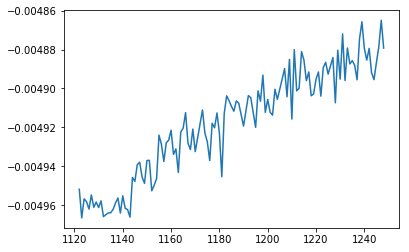

In [371]:
# Check Baselines
column = "116"

baseline = hdf5_file['/raw_data/baselines']
#baseline = baseline[baseline["Filenumber"] == 8979]
plt.plot(baseline["Filenumber"], baseline[column])
plt.show()

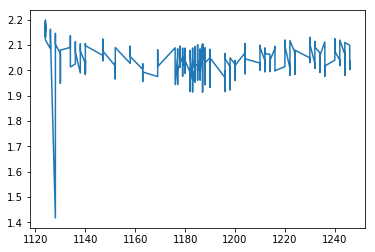

In [372]:
# Check Signals
column = "122"
sample = "SPEX 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_sub = signals[signals["Sample"] == sample]
plt.plot(signals_sub["Filenumber"], signals_sub[column])
plt.show()

In [373]:
df_mean(signals[signals["118"] < 0.05])

,Filenumber,Sample,110,111,112,113,114,115,116,117,...,120_2,121_2,122_2,123_2,124_2,125_2,126_2,127_2,129_2,131_2
Date,,,,,,,,,,,,,,,,,,,,,
2015-01-09 15:43:00,1122,blank sol,0.000134,0.000157,0.000370,0.000141,0.000395,0.000040,0.001515,0.000756,...,0.003484,0.000008,0.000508,1.905456e-05,0.000744,0.000242,0.000653,0.021037,0.016156,0.013265
2015-01-09 17:44:00,1132,blank sol,0.000085,0.000177,0.000444,0.000154,0.000464,0.000066,0.002150,0.001084,...,0.004542,0.000019,0.000666,2.354242e-05,0.000895,0.000195,0.000556,0.019284,0.016641,0.013652
2015-01-09 19:44:00,1142,blank sol,0.000086,0.000183,0.000483,0.000163,0.000495,0.000080,0.002243,0.001139,...,0.005188,0.000025,0.000745,2.273353e-05,0.000994,0.000160,0.000471,0.017836,0.017283,0.014198
2015-01-09 21:56:00,1153,blank sol,0.000169,0.000198,0.000498,0.000171,0.000519,0.000059,0.002342,0.001158,...,0.005934,0.000022,0.000808,1.640928e-05,0.001097,0.000138,0.000421,0.016595,0.017498,0.014372
2015-01-10 00:07:00,1164,blank sol,0.000186,0.000190,0.000506,0.000193,0.000517,0.000049,0.002492,0.001237,...,0.005315,0.000014,0.000712,1.081737e-05,0.000966,0.000143,0.000350,0.015609,0.017478,0.014353
2015-01-10 01:18:00,1170,blank sol,0.000180,0.000174,0.000482,0.000182,0.000508,0.000077,0.002434,0.001205,...,0.005263,0.000026,0.000710,1.308401e-05,0.000939,0.000100,0.000299,0.014974,0.017893,0.014696
2015-01-10 03:30:00,1181,blank sol,0.000165,0.000176,0.000478,0.000161,0.000484,0.000074,0.002446,0.001219,...,0.005239,0.000011,0.000713,3.686643e-05,0.000953,0.000079,0.000282,0.014422,0.018082,0.014828
2015-01-10 06:27:00,1192,blank sol,0.000163,0.000191,0.000454,0.000182,0.000477,0.000064,0.002194,0.001106,...,0.005490,0.000016,0.000738,1.224926e-05,0.001003,0.000109,0.000332,0.013689,0.017599,0.014459
2015-01-10 08:27:00,1202,blank sol,0.000172,0.000185,0.000498,0.000165,0.000511,0.000068,0.002548,0.001259,...,0.005309,0.000013,0.000713,2.627681e-05,0.000926,0.000078,0.000250,0.013397,0.017567,0.014444


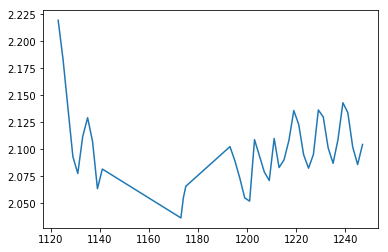

In [374]:
# Check Signals - mean
column = "122"
sample = "NIST 100ppb"

signals = hdf5_file['/raw_data/signals_zero']
signals_mean = df_mean(signals)
signals_sub_mean = signals_mean[signals_mean["Sample"] == sample]
plt.plot(signals_sub_mean["Filenumber"], signals_sub_mean[column])
plt.show()

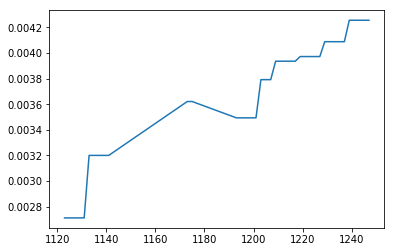

In [375]:
# Check background 
column = "118"
sample = "NIST 100ppb"

background = hdf5_file['/evaluation/bgd_outlier_corr/df_bgd_corr']
background_sub = background[background["Sample"] == sample]
plt.plot(background_sub["Filenumber"], background_sub[column])
plt.show()

In [376]:
background_mean = df_mean(background)

In [377]:
# Create Dataframe for signals_bgd corr
signals["Te/Sn"] = (signals["125_2"]/7.050686)/(signals["118"]/24.223)
signals["Cd/Sn"] = (signals["111"]/12.9447)/(signals["118"]/24.223)

In [378]:
signals_mean = signals.groupby("Filenumber").agg("mean")

# Outlier rejection

In [379]:
bgd_method = 'bgd_outlier_corr' #'no_bgd_corr'
norm_ratio = "r_116_120"
interf_corr = "Te125_Xe129_corr"

In [380]:
df_all_raw_rat = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_raw_ratios_af_interf_corr']
df_mean_int_corr = df_mean(hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_amount_interf_corr'])
df_all = hdf5_file['/evaluation/'+bgd_method+'/' +norm_ratio + '/'+interf_corr+'/df_internal_norm']

In [381]:
column = "124/120"
sample = "NIST 100ppb"

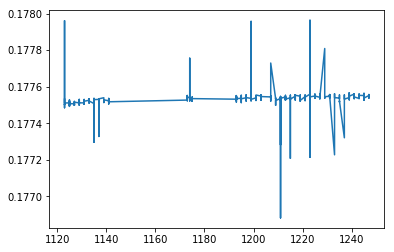

In [382]:
# Check ratios for bracketing standard

df_all_sub = df_all[df_all["Sample"] == sample]
plt.plot(df_all_sub["Filenumber"], df_all_sub[column])
plt.show()

In [383]:
df_outlier_rej_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_int = df_all.groupby(df_all["Filenumber"]).apply(mad_outlier)

df_outlier_rej_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier_rejection)
df_outlier_raw = df_all_raw_rat.groupby(df_all_raw_rat["Filenumber"]).apply(mad_outlier)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in divide
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in greater
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in divide


In [384]:
df_outlier_rej_int

,Sample,Num_of_Ana_Cyc,Cycle,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120
Date,,,,,,,,,,,,,
2015-01-09 15:54:00,NIST 100ppb,2,1,1123,0.029813,0.020195,0.010359,0.446,0.235287,0.742940,0.263479,NaN,0.177532
2015-01-09 15:54:00,NIST 100ppb,2,2,1123,0.029825,0.020199,0.010357,0.446,0.235291,0.742955,0.263456,0.142070,0.177502
2015-01-09 15:54:00,NIST 100ppb,2,3,1123,0.029822,0.020193,0.010357,0.446,0.235303,0.742967,0.263460,0.142068,0.177505
2015-01-09 15:54:00,NIST 100ppb,2,4,1123,0.029822,0.020198,0.010356,0.446,0.235303,0.742958,0.263451,0.142066,0.177492
2015-01-09 15:54:00,NIST 100ppb,2,5,1123,0.029819,0.020193,0.010362,0.446,0.235301,0.742941,0.263451,0.142062,0.177493
2015-01-09 15:54:00,NIST 100ppb,2,6,1123,NaN,NaN,NaN,0.446,0.235308,0.742950,0.263451,0.142062,0.177485
2015-01-09 15:54:00,NIST 100ppb,2,7,1123,0.029821,0.020194,0.010362,0.446,0.235308,0.742952,0.263463,0.142070,0.177507
2015-01-09 15:54:00,NIST 100ppb,2,8,1123,0.029829,0.020195,0.010362,0.446,0.235301,0.742957,0.263461,0.142065,0.177489
2015-01-09 15:54:00,NIST 100ppb,2,9,1123,0.029827,0.020197,0.010356,0.446,0.235315,0.742954,0.263456,0.142064,0.177497


In [385]:
df_outlier_raw[df_outlier_raw[column].notnull()][column]

Filenumber  Date               
1123        2015-01-09 15:54:00    0.186680
1124        2015-01-09 16:06:00    0.186808
1130        2015-01-09 17:19:00    0.186936
            2015-01-09 17:19:00    0.186273
1135        2015-01-09 18:18:00    0.186321
1137        2015-01-09 18:43:00    0.186385
1143        2015-01-09 19:54:00    0.186537
1144        2015-01-09 20:06:00    0.186727
1148        2015-01-09 20:55:00    0.186528
1152        2015-01-09 21:44:00    0.186901
1154        2015-01-09 22:06:00    0.186569
1155        2015-01-09 22:18:00    0.186679
            2015-01-09 22:18:00    0.186983
1156        2015-01-09 22:30:00    0.187152
1157        2015-01-09 22:42:00    0.186949
1159        2015-01-09 23:06:00    0.186775
1160        2015-01-09 23:18:00    0.186447
1162        2015-01-09 23:43:00    0.186504
1183        2015-01-10 03:55:00    0.186743
1185        2015-01-10 04:24:00    0.186754
1199        2015-01-10 07:50:00    0.187143
1207        2015-01-10 09:25:00    0.186899


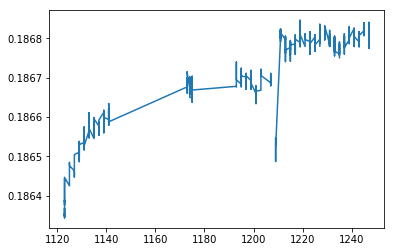

In [386]:
# Check sample measurements
df = df_outlier_rej_raw

df_sub = df[df["Sample"] == sample]
plt.plot(df_sub["Filenumber"], df_sub[column])
plt.show()

In [387]:
df[df["Sample"] == sample][column].std()

0.0001180944509888535

In [396]:
df_outlier_rej_int["Cd/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Cd/Sn"]
df_outlier_rej_int["Te/Sn"] = signals[(signals["Sample"] != "blank sol") & (signals["Sample"] != "SQ")]["Te/Sn"]

In [397]:
data_mean_int = df_mean(df_outlier_rej_int)
data_mean_int_sd = df_SD(df_outlier_rej_int)

data_mean_raw = df_mean(df_outlier_rej_raw)
data_mean_raw_sd = df_SD(df_outlier_rej_raw)

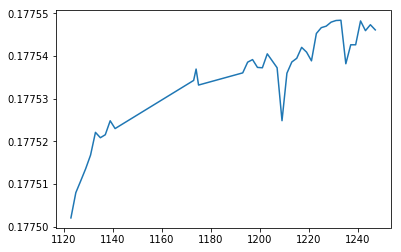

In [398]:
# Check sample measurements
df_mean_used = data_mean_int

df_mean_sub = df_mean_used[df_mean_used["Sample"] == sample]
plt.plot(df_mean_sub["Filenumber"], df_mean_sub[column])
plt.show()

In [399]:
data_mean_int

,Filenumber,Sample,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn
Date,,,,,,,,,,,,,
2015-01-09 15:54:00,1123,NIST 100ppb,0.029823,0.020195,0.010360,0.446,0.235304,0.742951,0.263454,0.142066,0.177502,0.000023,0.000095
2015-01-09 16:06:00,1124,SPEX 100ppb,0.029823,0.020196,0.010365,0.446,0.235299,0.742947,0.263448,0.142067,0.177505,0.000025,0.000095
2015-01-09 16:18:00,1125,NIST 100ppb,0.029824,0.020196,0.010359,0.446,0.235300,0.742950,0.263450,0.142069,0.177508,0.000025,0.000092
2015-01-09 16:31:00,1126,SPEX 100ppb,0.029826,0.020198,0.010367,0.446,0.235296,0.742945,0.263446,0.142069,0.177503,0.000024,0.000095
2015-01-09 16:43:00,1127,NIST 100ppb,0.029821,0.020193,0.010361,0.446,0.235303,0.742948,0.263448,0.142067,0.177511,0.000029,0.000096
2015-01-09 16:55:00,1128,SPEX 100ppb,0.029823,0.020195,0.010368,0.446,0.235299,0.742946,0.263447,0.142068,0.177508,0.000031,0.000094
2015-01-09 17:07:00,1129,NIST 100ppb,0.029824,0.020196,0.010359,0.446,0.235296,0.742946,0.263447,0.142071,0.177514,0.000027,0.000092
2015-01-09 17:19:00,1130,SPEX 100ppb,0.029825,0.020194,0.010364,0.446,0.235301,0.742947,0.263445,0.142069,0.177515,0.000030,0.000097
2015-01-09 17:32:00,1131,NIST 100ppb,0.029825,0.020193,0.010360,0.446,0.235302,0.742936,0.263446,0.142072,0.177517,0.000032,0.000091


In [400]:
date_list = []
                         
data_mean_raw = data_mean_raw.drop(date_list)
data_mean_int = data_mean_int.drop(date_list)
data_mean_raw_sd = data_mean_raw_sd.drop(date_list)
data_mean_int_sd = data_mean_int_sd.drop(date_list)

In [401]:
drop_sum = []

In [402]:

data_mean_int_sum = data_mean_int.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_int_sum = data_mean_int_sum.drop("Filenumber", axis=1)

In [403]:
data_mean_raw_sum = data_mean_raw.drop(drop_sum).groupby("Sample").agg(([np.mean, SD2, 'count']))
data_mean_raw_sum = data_mean_raw_sum.drop("Filenumber", axis=1)

In [404]:
data_mean_int_sum

112/120                   114/120                  \
                               mean       SD2 count      mean       SD2 count   
Sample                                                                          
NIST 100ppb                0.029824  0.000003    40  0.020195  0.000004    40   
SPEX 100ppb                0.029824  0.000003    45  0.020194  0.000004    45   
SPEX 100ppb + 0.004ppb In  0.029823  0.000004     5  0.020193  0.000002     5   
SPEX 100ppb + 0.040ppb Cd  0.029824  0.000003     5  0.020200  0.000004     5   
SPEX 100ppb + 0.1ppb Cd    0.029827  0.000004     5  0.020210  0.000003     5   
SPEX 100ppb + 1ppb Te      0.029823  0.000002     5  0.020193  0.000002     5   

                            115/120                     116/120  ...  122/120  \
                               mean           SD2 count    mean  ...    count   
Sample                                                           ...            
NIST 100ppb                0.010360  2.391613e-06    40   0.446  ...       40   
SPEX 100ppb                0.010367  2.519274e-06    45   0.446  ...       45   
SPEX 100ppb + 0.004ppb In  0.010492  2.747889e-06     5   0.446  ...        5   
SPEX 100ppb + 0.040ppb Cd  0.010368  1.005950e-06     5   0.446  ...        5   
SPEX 100ppb + 0.1ppb Cd    0.010367  1.275979e-07     5   0.446  ...        5   
SPEX 100ppb + 1ppb Te      0.010367  3.718466e-06     5   0.446  ...        5   

                            124/120                     Cd/Sn                  \
                               mean       SD2 count      mean       SD2 count   
Sample                                                                          
NIST 100ppb                0.177535  0.000025    40  0.000031  0.000005    40   
SPEX 100ppb                0.177532  0.000021    45  0.000032  0.000004    45   
SPEX 100ppb + 0.004ppb In  0.177530  0.000009     5  0.000033  0.000003     5   
SPEX 100ppb + 0.040ppb Cd  0.177529  0.000011     5  0.000315  0.000002     5   
SPEX 100ppb + 0.1ppb Cd    0.177531  0.000009     5  0.000741  0.000005     5   
SPEX 100ppb + 1ppb Te      0.177529  0.000010     5  0.000034  0.000002     5   

                              Te/Sn                  
                               mean       SD2 count  
Sample                                               
NIST 100ppb                0.000061  0.000033    40  
SPEX 100ppb                0.000060  0.000030    45  
SPEX 100ppb + 0.004ppb In  0.000071  0.000017     5  
SPEX 100ppb + 0.040ppb Cd  0.000069  0.000012     5  
SPEX 100ppb + 0.1ppb Cd    0.000070  0.000013     5  
SPEX 100ppb + 1ppb Te      0.006095  0.000008     5  

[6 rows x 33 columns]

In [406]:
date_list = []


epsilon_int_NIST = SSB(data_mean_int.drop(date_list), "NIST 100ppb", 10000)
delta_raw_NIST = SSB(data_mean_raw.drop(date_list), "NIST 100ppb", 1000)
epsilon_int_SPEX = SSB(data_mean_int.drop(date_list), "SPEX 100ppb", 10000)
delta_raw_SPEX = SSB(data_mean_raw.drop(date_list), "SPEX 100ppb", 1000)

In [407]:
epsilon_int_SPEX

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Cd/Sn,Te/Sn,Sample
Date,,,,,,,,,,,,,
2015-01-09 16:06:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,SPEX 100ppb
2015-01-09 16:18:00,0.000000,-0.211994,-0.591786,-6.920336,0.000000e+00,0.116543,0.052200,0.117499,0.098497,0.218591,248.848371,-268.532930,NIST 100ppb
2015-01-09 16:31:00,0.000000,0.882535,1.271188,0.571790,2.220446e-12,-0.127695,-0.022661,-0.071773,0.068389,-0.186595,-1457.825239,-5.491304,SPEX 100ppb
2015-01-09 16:43:00,0.000000,-1.134263,-1.422329,-6.713256,2.220446e-12,0.226127,0.031400,0.050140,-0.088363,0.300953,617.609328,172.016203,NIST 100ppb
2015-01-09 16:55:00,0.000000,-0.783528,-0.754474,2.427057,-1.110223e-12,0.015368,-0.002445,0.069314,-0.064999,-0.072370,1395.798495,-220.775628,SPEX 100ppb
2015-01-09 17:07:00,0.000000,-0.135534,0.470364,-6.868701,2.220446e-12,-0.157168,-0.012222,0.017518,0.121067,0.127037,-1244.670312,-392.327597,NIST 100ppb
2015-01-09 17:19:00,-8.841733,1.023502,-0.192770,-2.890007,2.220446e-12,0.120231,0.038428,-0.083380,-0.026243,-0.011029,-213.779804,914.150488,SPEX 100ppb
2015-01-09 18:06:00,8.826125,-1.079905,0.244773,0.107718,0.000000e+00,-0.140022,-0.037966,0.200751,0.103609,0.403180,66.592969,-479.927900,SPEX 100ppb
2015-01-09 18:18:00,0.000000,0.161857,-0.773658,-9.515720,0.000000e+00,-0.091132,-0.048392,0.210310,0.013754,0.096851,-59.928704,702.228953,NIST 100ppb


In [408]:

date_list = []

epsilon_int_NIST = epsilon_int_NIST.drop(date_list)
delta_raw_NIST = delta_raw_NIST.drop(date_list)

In [409]:
epsilon_int_NIST = epsilon_int_NIST.drop(["Cd/Sn", "Te/Sn"], axis=1)
epsilon_int_SPEX = epsilon_int_SPEX.drop(["Cd/Sn", "Te/Sn"], axis=1)

In [410]:
def epsilon_process(df):
    df = df[(df["Filenumber"] >= -5) & (df["Filenumber"] <= 5)]
    df["Filenumber"] = data_mean_int["Filenumber"].ix[df.index]
    return df

In [411]:
epsilon_int_NIST = epsilon_process(epsilon_int_NIST)
delta_raw_NIST = epsilon_process(delta_raw_NIST)
epsilon_int_SPEX = epsilon_process(epsilon_int_SPEX)
delta_raw_SPEX = epsilon_process(delta_raw_SPEX)

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [412]:
epsilon_int_NIST

,Filenumber,112/120,114/120,115/120,116/120,117/120,118/120,119/120,122/120,124/120,Sample
Date,,,,,,,,,,,
2015-01-09 16:06:00,1124,-0.139861,0.285129,5.653996,2.220446e-12,-0.140839,-0.045344,-0.159004,-0.034291,0.004378,SPEX 100ppb
2015-01-09 16:18:00,1125,0.550577,0.744214,-1.087890,2.220446e-12,-0.142936,0.005926,-0.043716,0.191832,0.088487,NIST 100ppb
2015-01-09 16:31:00,1126,1.114453,1.642770,7.107521,0.000000e+00,-0.235179,-0.053131,-0.119705,0.029128,-0.353061,SPEX 100ppb
2015-01-09 16:43:00,1127,-0.911052,-1.103298,1.680791,0.000000e+00,0.190276,-0.001143,-0.018598,-0.196449,-0.001346,NIST 100ppb
2015-01-09 16:55:00,1128,0.243136,0.098774,8.009793,-1.110223e-12,-0.026795,-0.010811,0.000828,-0.048852,-0.250174,SPEX 100ppb
2015-01-09 17:07:00,1129,0.306161,1.231983,-1.199237,0.000000e+00,-0.252235,0.050549,-0.007994,0.058696,-0.010926,NIST 100ppb
2015-01-09 17:19:00,1130,0.334092,0.192392,4.536823,0.000000e+00,0.088894,0.085804,-0.043858,-0.134584,-0.014825,SPEX 100ppb
2015-01-09 17:32:00,1131,0.455567,-1.620426,1.685251,2.220446e-12,0.211130,-0.111798,-0.041386,-0.016758,-0.059658,NIST 100ppb
2015-01-09 17:54:00,1133,-0.298116,1.678520,-1.333701,-1.110223e-12,-0.091976,0.069151,0.002072,0.188517,0.185439,NIST 100ppb


In [413]:
epsilon_NIST_sum = np.round(epsilon_int_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_NIST_sum = np.round(delta_raw_NIST.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
epsilon_SPEX_sum = np.round(epsilon_int_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)
delta_raw_SPEX_sum = np.round(delta_raw_SPEX.groupby("Sample").agg([np.mean, SD2, 'count']), decimals=3)

epsilon_sum_all = epsilon_NIST_sum.append(epsilon_SPEX_sum)
epsilon_sum_all = epsilon_sum_all.drop("Filenumber", axis=1)
delta_raw_sum_all = delta_raw_NIST_sum.append(delta_raw_SPEX_sum)
delta_raw_sum_all = delta_raw_sum_all.drop("Filenumber", axis=1)

In [414]:
epsilon_sum_all

112/120              114/120              115/120               \
               mean    SD2 count    mean    SD2 count    mean    SD2 count   
Sample                                                                       
NIST 100ppb  -0.039  1.188    32  -0.032  1.791    32   0.027  2.084    32   
SPEX 100ppb  -0.077  1.238    26  -0.066  1.598    26   6.957  2.746    26   
NIST 100ppb   0.043  1.271    19   0.116  1.583    19  -6.988  2.064    19   
SPEX 100ppb   0.093  1.335    27  -0.003  2.089    27   0.204  3.577    27   

            116/120  ...  118/120 119/120              122/120               \
               mean  ...    count    mean    SD2 count    mean    SD2 count   
Sample               ...                                                      
NIST 100ppb     0.0  ...       32  -0.006  0.143    32  -0.003  0.221    32   
SPEX 100ppb     0.0  ...       26  -0.045  0.187    26  -0.016  0.121    26   
NIST 100ppb     0.0  ...       19   0.037  0.189    19   0.005  0.136    19   
SPEX 100ppb     0.0  ...       27   0.000  0.231    27   0.005  0.208    27   

            124/120               
               mean    SD2 count  
Sample                            
NIST 100ppb   0.002  0.373    32  
SPEX 100ppb  -0.093  0.406    26  
NIST 100ppb   0.127  0.316    19  
SPEX 100ppb  -0.014  0.343    27  

[4 rows x 27 columns]

In [415]:
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_int_outlier_corr_all', df_outlier_rej_int, min_itemsize = {"Sample": 50})
#hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_raw_outlier_corr_all', df_outlier_rej_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_int', data_mean_int, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_mean_raw', data_mean_raw, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int', epsilon_int_NIST.append(epsilon_int_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_delta_raw', delta_raw_NIST.append(delta_raw_SPEX), min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/signals_mean', signals_mean, min_itemsize = {"Sample": 50})
hdf5_sum_file.append('/data_final/'+bgd_method +'/background_mean', background_mean, min_itemsize = {"Sample": 50})

NameError: name 'hdf5_sum_file' is not defined

In [258]:
hdf5_sum_file['/data_final/'+bgd_method + '/'  +norm_ratio + '/' + interf_corr +'/data_epsilon_int']

NameError: name 'hdf5_sum_file' is not defined

# Raw data to xls file

In [259]:
signals_raw = hdf5_file['/raw_data/signals_raw']

In [260]:
writer_raw = pd.ExcelWriter(path+'raw_data.xlsx', engine='xlsxwriter')

baseline.to_excel(writer_raw, index=True, sheet_name='baseline')
signals_raw.to_excel(writer_raw, index=True, sheet_name='signals_raw')
signals.to_excel(writer_raw, index=True, sheet_name='signals_baseline_corr')
#background.to_excel(writer_raw, index=True, sheet_name='background')

writer_raw.save()

In [416]:
writer_orig = pd.ExcelWriter(path+ bgd_method + '_'  +norm_ratio + '_' + interf_corr +'_bgd_new_den_2.xlsx', engine='xlsxwriter')


In [417]:
df_mean_int_corr.to_excel(writer_orig, index=True, sheet_name='amount_interf_corr_all')
df_all.to_excel(writer_orig, index=True, sheet_name='data_int_norm_all')
df_all_raw_rat.to_excel(writer_orig, index=True, sheet_name='data_raw_ratios_all')
df_outlier_int.to_excel(writer_orig, index=True, sheet_name='data_int_outliers_all')
data_mean_int_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_int_sd')
data_mean_int_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_int_summary')
data_mean_raw_sd.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_sd')
data_mean_raw_sum.to_excel(writer_orig, index=True, sheet_name='data_mean_raw_summary')
epsilon_int_NIST.append(epsilon_int_SPEX).to_excel(writer_orig, index=True, sheet_name='epsilon_int_SSB')
epsilon_sum_all.to_excel(writer_orig, index=True, sheet_name='epsilon_int_SBB_summary')
delta_raw_NIST.append(delta_raw_SPEX).to_excel(writer_orig, index=True, sheet_name='delta_raw_SSB')
delta_raw_sum_all.to_excel(writer_orig, index=True, sheet_name='delta_raw_SBB_summary')

In [418]:
writer_orig.save()

In [111]:
hdf5_sum_file.flush()
hdf5_sum_file.close()

NameError: name 'hdf5_sum_file' is not defined

In [ ]:
# create by plots for selected column
sel_ratio = ["eSn_122_118"]

# defines limits on x-axis
xlim = [-4, 4]

# creates figure
fig = plt.figure(figsize=(10,15))

# iterates over selected ratios and creates plots
for i in range(len(sel_ratio)):
    ax = plt.subplot(5,2,i+1)
    plot_epsilon(sel_ratio[i], "NIST + DS 0.5-0.5", xlim)
fig.tight_layout()
plt.show()
#wb.sheets[4].pictures.add(fig, name= '116/120 norm - bgd_corr 1', update = True)
#fig.savefig(path+"DS_epsilon_x_bgd_122_118_100ppb_mixtures.pdf", bbox_inches='tight')

In [363]:
hdf5_file.flush()
hdf5_file.close()

In [ ]:
# creates a single plot to show mixtures against fspike

std = "NIST + DS 0.5-0.5"
sel_ratio = "eSn_122_118"
sel_var = "fspike"

fig2 = plt.figure(figsize=(10,7))
plt.errorbar(df_DS_inv_mean_sample_sd[df_DS_inv_mean_sample_sd.index.str.contains("NIST")][sel_var]["mean"], epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["mean"] , yerr = epsilon_sum[epsilon_sum.index.str.contains("NIST")][sel_ratio]["SD2"], ls='none', marker="o")
plt.title(std + ", 2SD = " + str(np.round((2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std()),2)) + ", n= " +  str((epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].count())))
plt.xlim([0, 1])
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean(), color='k', linestyle='-')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()+ 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
plt.axhline(epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].mean()- 2*epsilon_comp[epsilon_comp["sample"]== std][sel_ratio].std(), color='r', linestyle='--')
    #plt.axvline(plot_Nist[sel_ratio].mean()- 2*plot_Nist[sel_ratio].std(), color='r', linestyle='--')
plt.ylabel(r'$\mathregular{\epsilon^{'+sel_ratio+'}}$Sn$_{NIST}$')
plt.xlabel(sel_var)
plt.show()
#fig2.savefig(path+"DS_epsilon_122_118_fspike_100ppb_mixtures.pdf", bbox_inches='tight')